In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import pandas as pd
import seaborn as sns
import corner as corner

In [2]:
%matplotlib notebook

In [3]:
def Ensure_all(All_variables):
    no_nan_tables = [table.dropna() for table in All_variables]
    
    num_variables = len(no_nan_tables)
    previous_merge = no_nan_tables[0]
    for index in range(1, num_variables):
        current_table = no_nan_tables[index]
        previous_merge = pd.merge(previous_merge, current_table, left_index=True, right_index=True, how='inner')
    return previous_merge

def PlanetRadiusErrors(Ratio, Radius, RatioError, RadiusError):
    Error = np.sqrt((Ratio*RadiusError)**2 + (Radius*RatioError)**2)*const.R_sun/const.R_earth
    return Error

In [4]:
Main_directory = 'C:/Users/Iwan/Documents/GitHub/Iwan-and-George-Year-4-Project'

Gaia_stars = pd.read_csv(f'{Main_directory}/Samples/Sorted Data/Stars/Gaia All Stars.csv', index_col='Gaia DR3 ID').dropna()
BASTA_stars = pd.read_csv(f'{Main_directory}/BASTA/Output/GaiaResultsFinal.ascii', index_col='starid' ,sep='\t').dropna()
Planet_data = pd.read_csv(f'{Main_directory}/Samples/Sorted Data/Planets/Final Planets.csv'
                          , index_col='KOI').dropna()

add_sys = True
if add_sys:
    Gaia_stars['Rad pe'] += 0.035*Gaia_stars['Radius']
    Gaia_stars['Rad me'] += 0.035*Gaia_stars['Radius']
    Gaia_stars['Teff pe'] = np.sqrt(Gaia_stars['Teff pe']**2 + 102**2)
    Gaia_stars['Teff me'] = np.sqrt(Gaia_stars['Teff me']**2 + 102**2)

Planet_calc = Planet_data.set_index('Host Gaia DR3 ID')
Valley_data = Ensure_all([Gaia_stars[['Radius', 'Rad pe', 'Rad me']], Planet_calc])

Valley_data['Planet Radii'] = Valley_data['Radius']*Valley_data['PSR']*const.R_sun/const.R_earth
Valley_data['Planet Rad pe'] = PlanetRadiusErrors(Valley_data['PSR'], Valley_data['Radius']
                                                  , Valley_data['PSR pme'], Valley_data['Rad pe'])
Valley_data['Planet Rad me'] = PlanetRadiusErrors(Valley_data['PSR'], Valley_data['Radius']
                                                  , Valley_data['PSR pme'], Valley_data['Rad me'])
Valley_data.reset_index(inplace=True)
Valley_data = Valley_data.drop(Valley_data[Valley_data['Planet Radii'] > 4].index)

print(Valley_data)

             Gaia DR3 ID    Radius    Rad pe    Rad me          P  \
0      58200934326315136  1.088636  0.049833  0.055451  41.685500   
2     111322601672419712  1.068451  0.045063  0.043883   3.652815   
3     145333927996558976  0.554846  0.039208  0.039202   6.342000   
4     145333927996558976  0.554846  0.039208  0.039202  13.850000   
5     145333927996558976  0.554846  0.039208  0.039202  40.718000   
..                   ...       ...       ...       ...        ...   
700  6258810550587404672  1.634996  0.093128  0.093574   1.621160   
701  6264513270727342080  0.650503  0.041730  0.041621  27.359000   
710  6541360574788758016  0.774938  0.044294  0.044296   7.610303   
711  6541360574788758016  0.774938  0.044294  0.044296  14.245648   
715  6683371847364921088  0.753877  0.043545  0.043545   6.443868   

             P pe          P me       PSR   PSR pme  Planet Radii  \
0    3.000000e-03  3.000000e-03  0.022136  0.000565      2.628521   
2    7.600000e-07  7.500000e-07  

In [5]:
Gaia_stars.drop(columns=Gaia_stars.columns[7:], inplace=True)
Gaia_stars.dropna(inplace=True)

def LuminosityErrors(Radius, Teff, RadiusError, TeffError):
    Error = 2*Radius*Teff**3/5772**4*np.sqrt(Teff**2*RadiusError**2 + 4*Radius**2*TeffError**2)
    return Error

Gaia_stars['Luminosity'] = Gaia_stars['Radius']**2*(Gaia_stars['Teff']/5772)**4
Gaia_stars['Luminosity pe'] = LuminosityErrors(Gaia_stars['Radius'], Gaia_stars['Teff'], 
                                               Gaia_stars['Rad pe'], Gaia_stars['Teff pe'])
Gaia_stars['Luminosity me'] = LuminosityErrors(Gaia_stars['Radius'], Gaia_stars['Teff'], 
                                               Gaia_stars['Rad me'], Gaia_stars['Teff me'])


<IPython.core.display.Javascript object>


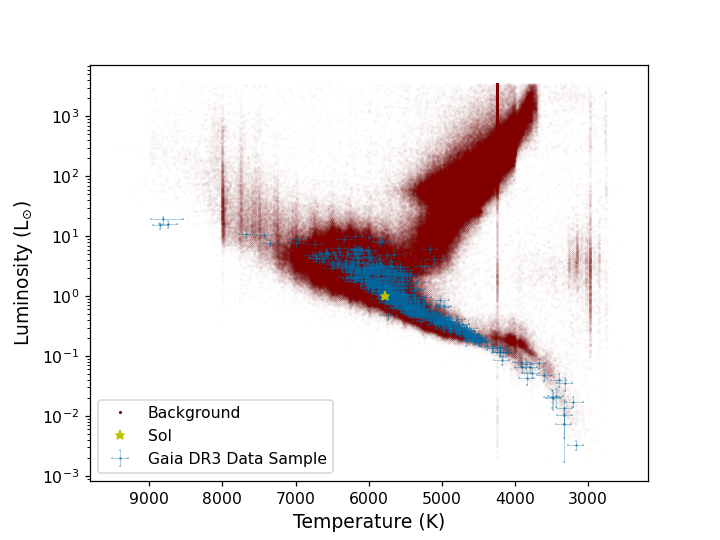

In [6]:
Colour = plt.style.use('tableau-colorblind10')

HR_data = pd.read_csv(f'{Main_directory}/Samples/Raw Data/HR Data (Flags).csv')

plt.figure()
plt.plot(6000, 1, '.', color='maroon', markersize=2, label='Background')
plt.plot(HR_data['teff_gspspec'], HR_data['lum_flame'], '.', color='maroon', markersize=0.1, alpha=0.3)
plt.errorbar(Gaia_stars['Teff'], Gaia_stars['Luminosity']
             , yerr=[Gaia_stars['Luminosity pe'], Gaia_stars['Luminosity me']]
             , xerr=[Gaia_stars['Teff pe'], Gaia_stars['Teff me']]
             , markersize=2, elinewidth=0.5, capsize=0.5, alpha=0.4 ,fmt='.', label='Gaia DR3 Data Sample')
plt.plot(5772, 1, 'y*', label='Sol', zorder=3)
plt.yscale('log')
plt.xlabel('Temperature (K)', fontsize=12)
plt.ylabel('Luminosity (L$_{\odot}$)', fontsize=12)
#plt.title('Gaia DR3 Star Sample', fontsize=12)
plt.gca().invert_xaxis()
plt.legend()
plt.savefig('Sample HR diagram')
plt.show()

<IPython.core.display.Javascript object>


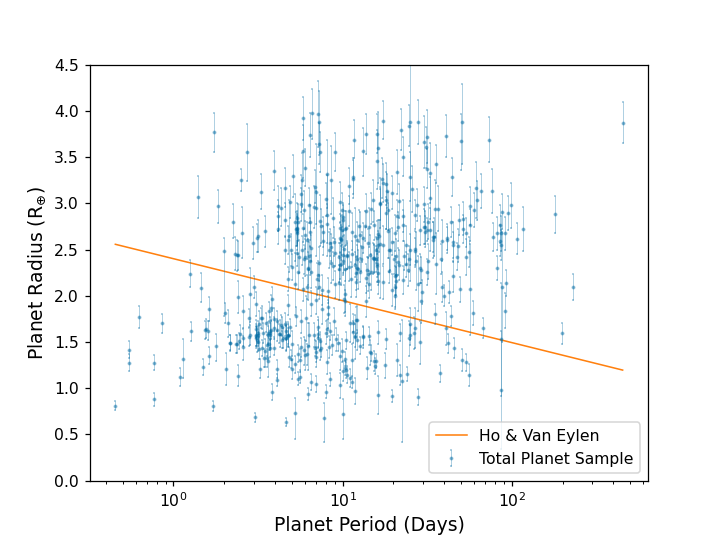

C:\Users\Iwan\AppData\Local\Temp\ipykernel_13228\3974151717.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(Valley_data['P'], Valley_data['Planet Radii']


In [7]:
x = np.linspace(min(Valley_data['P']), max(Valley_data['P']), 2)
m = -0.11
c = 0.37
y = 10**(m*np.log10(x) + c)

plt.figure()
plt.errorbar(Valley_data['P'], Valley_data['Planet Radii']
             , yerr=[Valley_data['Planet Rad pe'], Valley_data['Planet Rad me']]
             , markersize=1.5, marker='o', elinewidth=0.5, capsize=0.5, alpha=0.4 ,fmt='.', label='Total Planet Sample')
plt.plot(x, y, linewidth=1, zorder=1, label='Ho & Van Eylen')
plt.ylim(0, 4.5)
plt.xscale('log')
plt.ylabel('Planet Radius (R$_{\oplus}$)', fontsize=12)
plt.xlabel('Planet Period (Days)', fontsize=12)
plt.legend()
#plt.savefig('Pre BASTA Radius Valley')
plt.show()